# 🎤 Nick's Limitless Pendant Usage Analysis

Visualization of recording patterns and usage statistics from your Limitless pendant.

In [1]:
# Setup and data loading (click to expand)
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import date
import os
from dotenv import load_dotenv

load_dotenv('../python/.env')

def download_lifelogs(date_str=None, page_size=10):
    """Download lifelogs from the Limitless API"""
    if date_str is None:
        date_str = date.today().isoformat()
    
    url = "https://api.limitless.ai/v1/lifelogs"
    api_key = os.getenv("LIMITLESS_API_KEY")
    
    params = {
        "includeMarkdown": "false",
        "direction": "asc",
        "limit": page_size,
        "includeHeadings": "false"
    }
    
    headers = {"X-API-Key": api_key}
    all_lifelogs = []
    
    while True:
        response = requests.get(url, params=params, headers=headers)
        data = response.json()
        lifelogs = data.get('data', {}).get('lifelogs', [])
        
        if not lifelogs:
            break
        
        all_lifelogs.extend(lifelogs)
        next_cursor = data.get('meta', {}).get('lifelogs', {}).get('nextCursor', None)
        if next_cursor:
            params["cursor"] = next_cursor
        else:
            break
    
    lifelog_data = []
    for log in all_lifelogs:
        if 'contents' in log and log['contents']:
            first_time = log['contents'][0]['startTime']
            last_time = log['contents'][-1]['startTime']
            lifelog_data.append({
                'first_timestamp': first_time,
                'last_timestamp': last_time,
                'title': log.get('title', 'Untitled')
            })
    
    df = pd.DataFrame(lifelog_data)
    if not df.empty:
        df['first_timestamp'] = pd.to_datetime(df['first_timestamp'])
        df['last_timestamp'] = pd.to_datetime(df['last_timestamp'])
    
    return df

# Load the data
df = download_lifelogs()
print(f"✅ Loaded {len(df)} recording sessions")

/Users/ndeltortoiii/limitless-api-examples/python/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✅ Loaded 106 recording sessions


## 📊 Recording Timeline

/var/folders/01/7zsfb41x7c52q99sm20l6hb80000gn/T/ipykernel_34781/2858250151.py:36: UserWarning: Glyph 127908 (\N{MICROPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ndeltortoiii/limitless-api-examples/python/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ndeltortoiii/limitless-api-examples/python/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127908 (\N{MICROPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


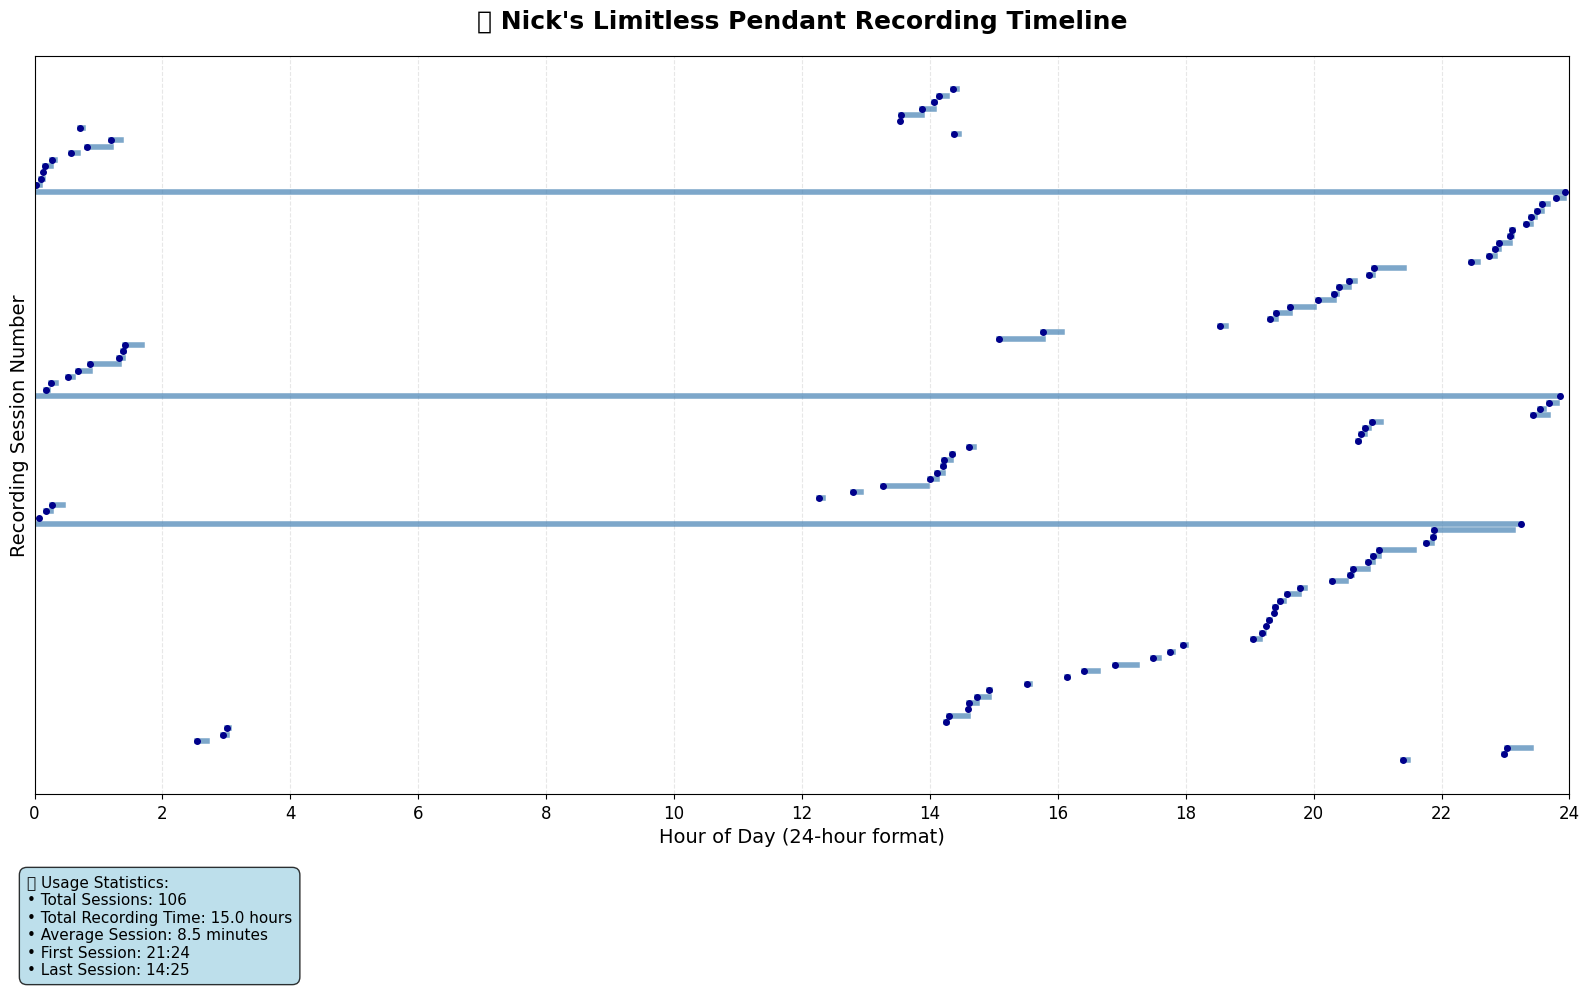

In [2]:
# Create timeline visualization
plt.figure(figsize=(16, 10))

for i, row in df.iterrows():
    start_hour = row['first_timestamp'].hour + row['first_timestamp'].minute/60
    end_hour = row['last_timestamp'].hour + row['last_timestamp'].minute/60
    
    plt.plot([start_hour, end_hour], [i, i], linewidth=4, color='steelblue', alpha=0.7)
    plt.plot(start_hour, i, marker='o', markersize=4, color='darkblue')

plt.title('🎤 Nick\'s Limitless Pendant Recording Timeline', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Hour of Day (24-hour format)', fontsize=14)
plt.ylabel('Recording Session Number', fontsize=14)

plt.xticks(range(0, 25, 2), fontsize=12)
plt.xlim(0, 24)
plt.grid(True, linestyle='--', alpha=0.3)
plt.yticks([])

# Statistics
total_recording_time = sum((row['last_timestamp'] - row['first_timestamp']).total_seconds()/3600 
                          for _, row in df.iterrows())
earliest_recording = df['first_timestamp'].min().strftime('%H:%M')
latest_recording = df['last_timestamp'].max().strftime('%H:%M')

stats_text = f"""📊 Usage Statistics:
• Total Sessions: {len(df)}
• Total Recording Time: {total_recording_time:.1f} hours
• Average Session: {(total_recording_time/len(df)*60):.1f} minutes
• First Session: {earliest_recording}
• Last Session: {latest_recording}"""

plt.figtext(0.02, 0.02, stats_text, fontsize=11, 
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

## 📈 Usage by Hour

/var/folders/01/7zsfb41x7c52q99sm20l6hb80000gn/T/ipykernel_34781/3808600519.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ndeltortoiii/limitless-api-examples/python/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


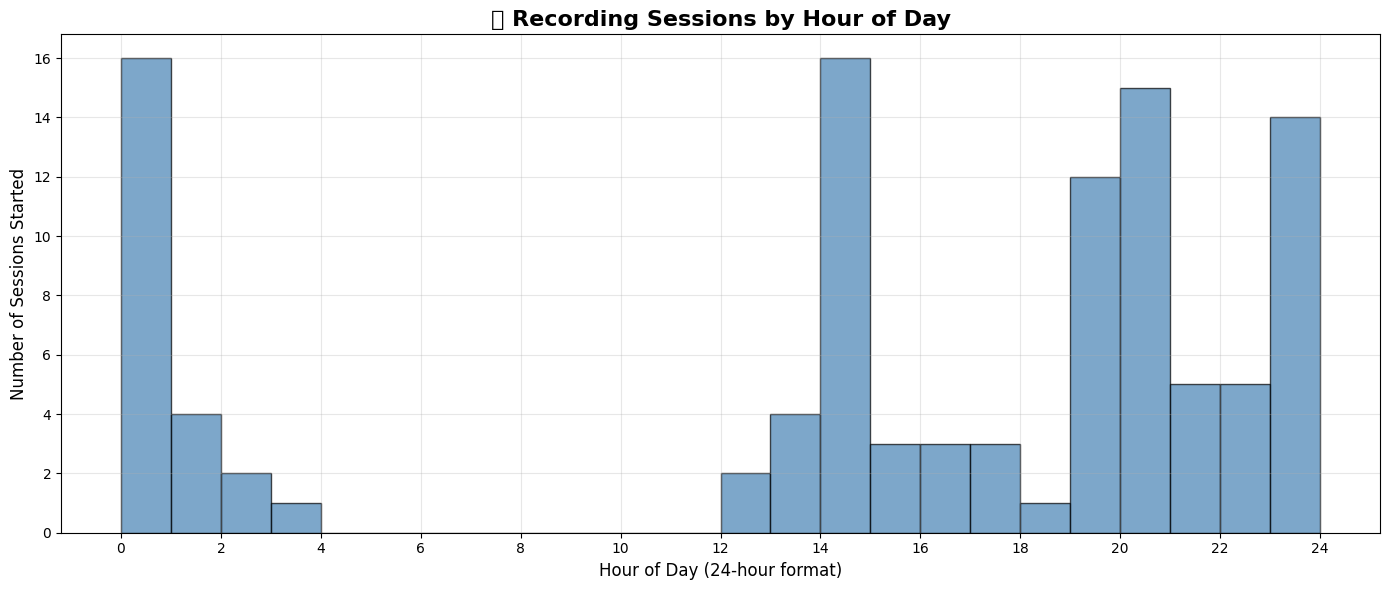

🔥 Peak usage hour: 00:00 with 16 sessions
🌅 Morning (6-12): 0 sessions
☀️  Afternoon (12-18): 31 sessions
🌙 Evening (18-24): 52 sessions
🌃 Night (0-6): 23 sessions


In [3]:
# Usage histogram
df['hour'] = df['first_timestamp'].dt.hour

plt.figure(figsize=(14, 6))
plt.hist(df['hour'], bins=24, range=(0, 24), alpha=0.7, color='steelblue', edgecolor='black')

plt.title('📊 Recording Sessions by Hour of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Number of Sessions Started', fontsize=12)
plt.xticks(range(0, 25, 2))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Usage insights
hour_counts = df['hour'].value_counts().sort_index()
peak_hour = hour_counts.idxmax()
peak_count = hour_counts.max()

print(f"🔥 Peak usage hour: {peak_hour:02d}:00 with {peak_count} sessions")
print(f"🌅 Morning (6-12): {len(df[(df['hour'] >= 6) & (df['hour'] < 12)])} sessions")
print(f"☀️  Afternoon (12-18): {len(df[(df['hour'] >= 12) & (df['hour'] < 18)])} sessions")
print(f"🌙 Evening (18-24): {len(df[(df['hour'] >= 18) & (df['hour'] < 24)])} sessions")
print(f"🌃 Night (0-6): {len(df[(df['hour'] >= 0) & (df['hour'] < 6)])} sessions")

---
### 📖 How to Read the Charts:
- **Timeline Chart**: Each horizontal line is one recording session
  - Position shows when it started during the day
  - Length shows how long it lasted
- **Histogram**: Shows your most active recording hours

*Generated from your Limitless pendant data*